In [667]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow.keras as K

import pickle
from zipfile import ZipFile, ZIP_DEFLATED

from skimage.color import rgb2gray, label2rgb
from lime import lime_image

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from lime.wrappers.scikit_image import SegmentationAlgorithm

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## FMNIST

Zbiór 60,000 obrazków 28x28 w skalai szarości przedstawiających jeden z 10 rodzajów ubrań. 

In [2]:
fashion_mnist = K.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

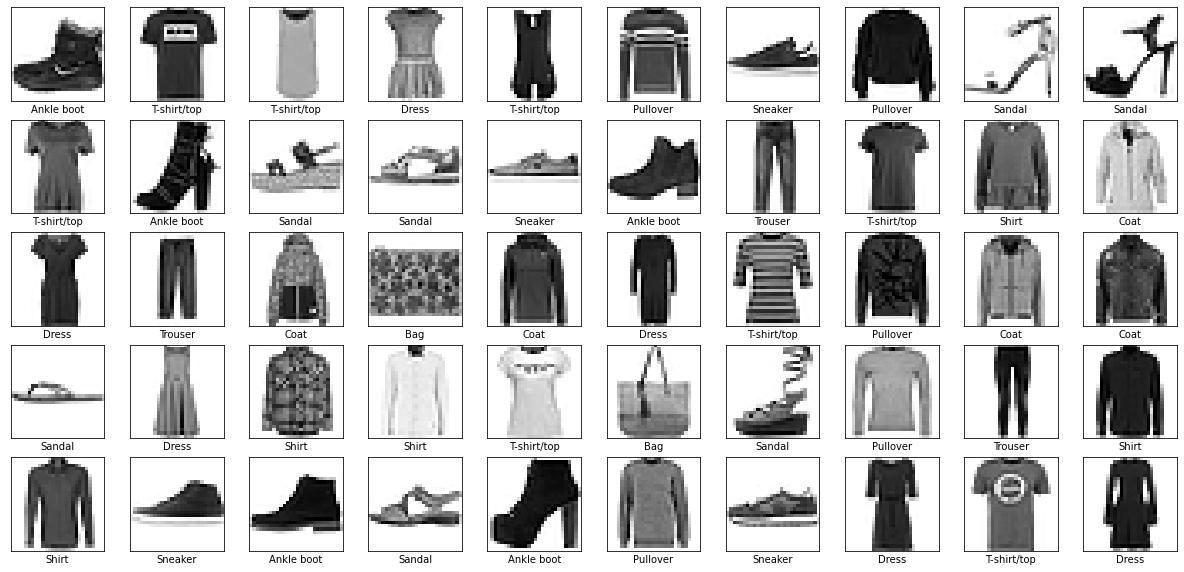

In [4]:
plt.figure(figsize=(21,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Bedziemy badać 2 klasyfikatory: SVM i Random Forest. Klasyfikatory przyjmują wektory jednowymiarowe więc trzeba wejście odpowiednio zreshapować.

In [5]:
reshape_2d = lambda X: X.reshape(X.shape[0], np.product(X.shape[1:]))

X_train = reshape_2d(train_images)
X_test = reshape_2d(test_images)

y_train = train_labels
y_test = test_labels

In [482]:
svc = make_pipeline(
    MinMaxScaler(),
    SVC(probability=True)
)

Trenowanie trwa kilka dobrych minut - polecamy ominąć poniższą komórkę i wczytać model w kolejnej. 

In [ ]:
%time svc.fit(X_train, y_train) #probability=True

In [483]:
with ZipFile('svc2.zip', 'r') as f:
    svc = pickle.loads(f.read('svc.pickle'))

Computing accuracy takes about 3 minutes

In [484]:
%time svc_predictions = svc.predict(X_test)
accuracy_score(y_test, svc_predictions)

CPU times: user 2min 48s, sys: 0 ns, total: 2min 48s
Wall time: 2min 50s


0.8829

Computing probabilities takes about 3 minutes.

In [536]:
%time svc_probabilities = svc.predict_proba(X_test)

CPU times: user 2min 18s, sys: 0 ns, total: 2min 18s
Wall time: 2min 18s


In [8]:
from sklearn.ensemble import RandomForestClassifier

forest = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=64, n_jobs=-1)
)

It takes about 1 minute to train RandomForestClassifier. Again you can skip the next cell and read the model in the following one. 

In [17]:
%time forest.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 274 ms, total: 1min 16s
Wall time: 20.9 s


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=64, n_jobs=-1))])

In [9]:
with ZipFile('forest.zip', 'r') as f:
    forest = pickle.loads(f.read('forest.pickle'))

In [10]:
%time forest_predictions = forest.predict(X_test)
accuracy_score(y_test, forest_predictions)

CPU times: user 470 ms, sys: 28.4 ms, total: 499 ms
Wall time: 248 ms


0.8732

In [535]:
%time forest_probabilities = forest.predict_proba(X_test)

CPU times: user 504 ms, sys: 45.4 ms, total: 549 ms
Wall time: 201 ms


We will use computed predictions and probabilities later so let's 'cache' them.

In [539]:
cache = {
    svc: {
        "predictions": svc_predictions,
        "probabilities": svc_probabilities
    },
    forest: {
        "predictions": forest_predictions,
        "probabilities": forest_probabilities
    }
}

In [668]:
def plot_confusion_matrix(classifier, title):
    confusion = confusion_matrix(y_test, cache[classifier]["predictions"])
    df_cm = pd.DataFrame(confusion, index = class_names.values(), columns = class_names.values())
    fig, ax = plt.subplots(1, 1, figsize = (15, 7))
    sn.heatmap(df_cm, cmap="rocket_r", annot=True)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('predicted', fontsize=14)    
    ax.set_ylabel('real', fontsize=14)

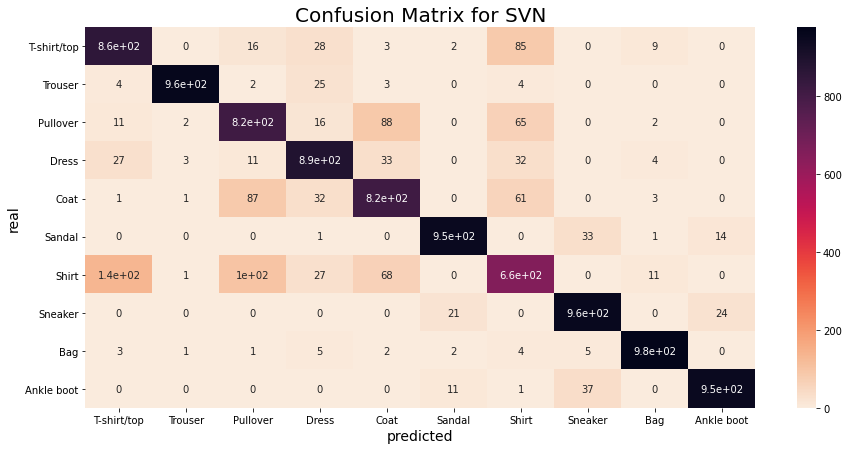

In [669]:
plot_confusion_matrix(svc, "Confusion Matrix for SVN")

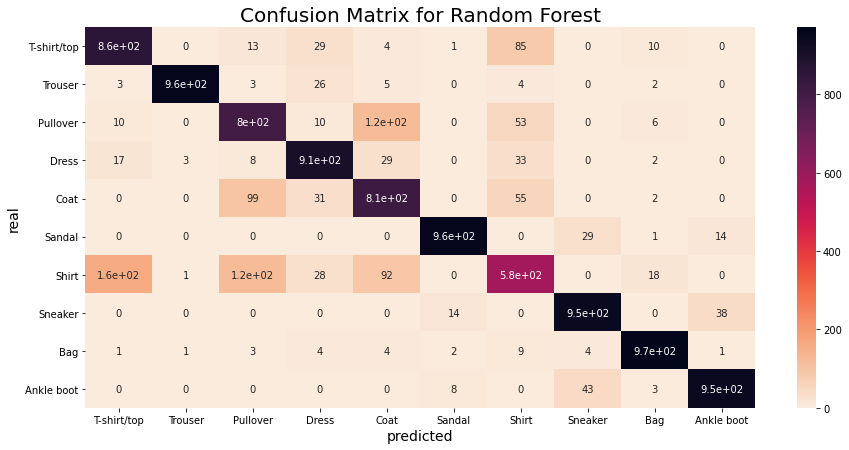

In [670]:
plot_confusion_matrix(forest, "Confusion Matrix for Random Forest")

In [606]:
def plot_predictions(probabilities, label, image):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 3), gridspec_kw={'width_ratios': [1, 2]})
    ax1.set_title(class_names[label], fontsize=12)
    ax1.imshow(image.reshape(28, 28))
    ax2.set_title("Probabilities", fontsize=12)
    ax2.bar(class_names.values(), probabilities)
    plt.show() 
    
def plot_top_mistakes(classifier, num=5):
    predictions = cache[classifier]["probabilities"]
    top_mistakes = sorted(zip(predictions, y_test, X_test), key=lambda x: x[0][x[1]])
    for (probas, label, image) in top_mistakes[:num]:
        plot_predictions(probas, label, image)
        
def plot_mistake(real, prediction, classifier, num=1):
    predictions = cache[classifier]["predictions"]
    indices = []
    for i in range(len(predictions)):
        if predictions[i] == prediction and y_test[i] == real:
            indices.append(i)
    for i in indices[:min(len(indices)+1, num)]:
        plot_predictions(cache[classifier]["probabilities"][i], y_test[i], X_test[i])
    return indices

Let's plot some top mistakes for SVN:

## SVM mistakes

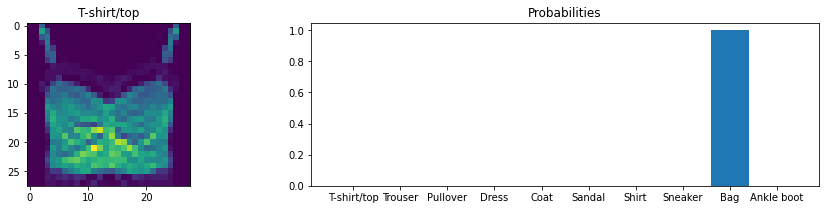

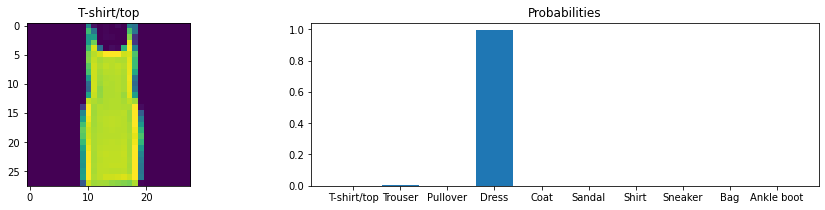

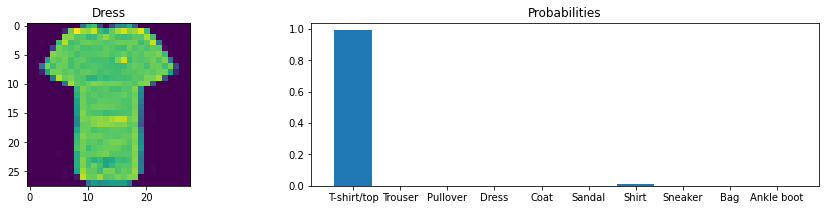

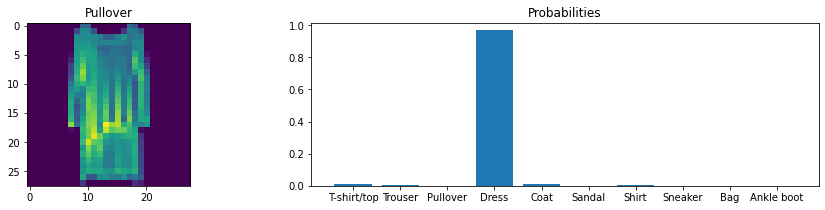

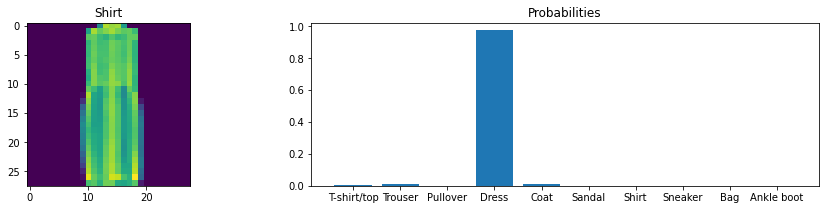

In [664]:
printmd("## SVM mistakes")
plot_top_mistakes(svc)

## Random Forest mistakes

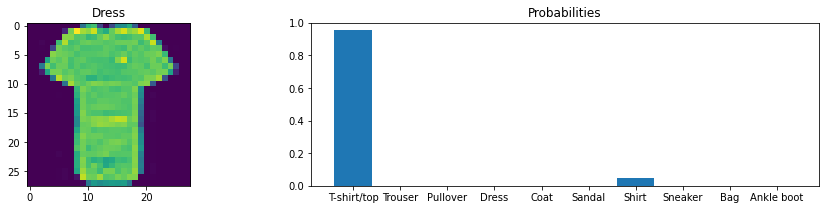

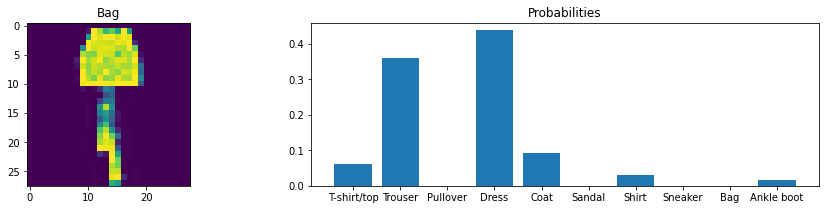

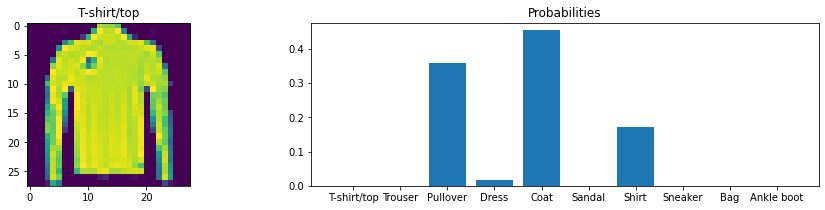

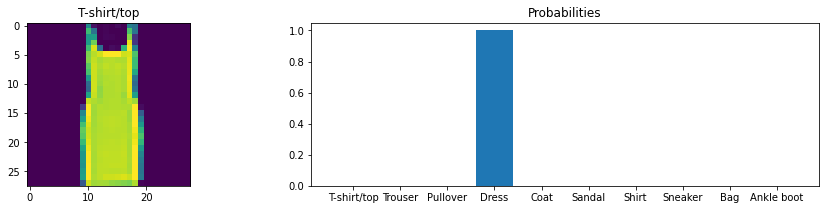

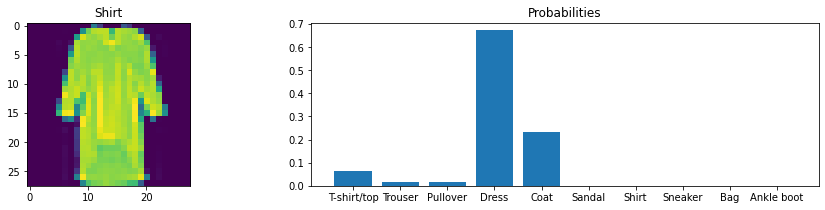

In [665]:
printmd("## Random Forest mistakes")
plot_top_mistakes(forest)

## LIME
Let's try to explain some classifications with LIME. In contrary to tabular explainer used before on wine dataset we gonna use `LimeImageExplainer`. It performs regression on images with pixels grouped into so called superpixels. We can customise the number and shape of superpixels by providing  appropriate`SegmentationAlgorithm`.   
Let's pick some example image.

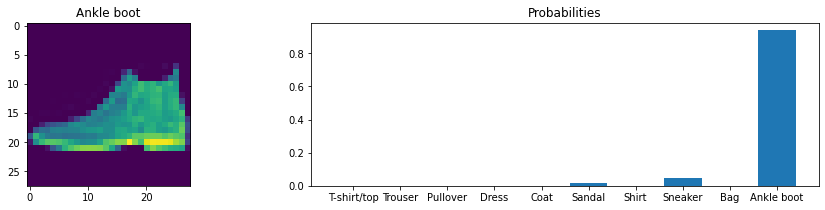

In [751]:
IMAGE_INDEX = 0
plot_predictions(cache[svc]["probabilities"][IMAGE_INDEX], y_test[IMAGE_INDEX], X_test[IMAGE_INDEX])

In [870]:
def svc_predict_proba(X):
    X = rgb2gray(X)
    X *= 255
    X = X.astype(np.uint8)
    X = X.reshape(*X.shape[:-2], np.product(X.shape[-2:]))
    return svc.predict_proba(X)

explainer = lime_image.LimeImageExplainer()

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=20, ratio=0.25)

explanation = explainer.explain_instance(X_test[IMAGE_INDEX].reshape(28,28), # input image, note the shape
                                         svc_predict_proba, # predict probabilities function
                                         labels=class_names.keys(), # dataset classes
                                         top_labels=10, # number of top labels took into account
                                         hide_color=0, # color which will be used for hiding superpixels
                                         num_samples=1000, # number of samples for which regression is calculated
                                         segmentation_fn=segmenter) # our segmentation algorithm

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's have a look on the given 'explenation'

#### Segments for QuickShift with kernel_size=1, max_dist=20, ratio=0.25

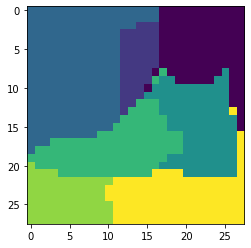

In [872]:
printmd("#### Segments for QuickShift with kernel_size=1, max_dist=20, ratio=0.25")
plt.imshow(explanation.segments)
plt.show()

In [873]:
printmd('#### Explanation top labels')
print([class_names[i] for i in explanation.top_labels])

#### Explanation top labels

['Ankle boot', 'Sneaker', 'Sandal', 'Bag', 'T-shirt/top', 'Pullover', 'Coat', 'Dress', 'Shirt', 'Trouser']


#### LIME interception

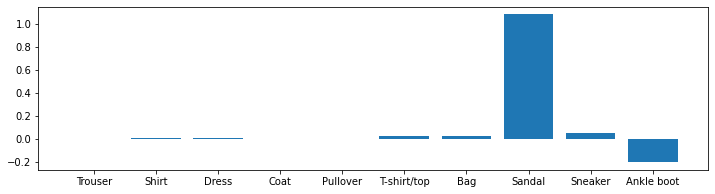

In [874]:
printmd("#### LIME interception")
plt.figure(figsize=(12,3))
plt.bar([class_names[i] for i in explanation.intercept.keys()], explanation.intercept.values())
plt.show()

Let's plot some explanation for the top label! You can play with `num_features` and `min_weight` to see more/less highlighted segments.

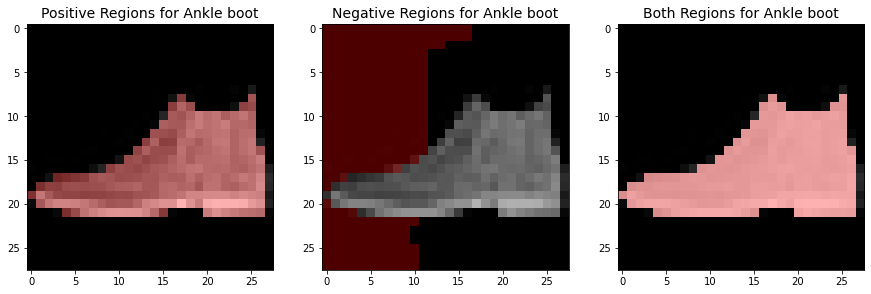

In [778]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# positive regions
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=2, # number of coloured segments 
                                            min_weight = 0.01 # min weight of the segment to be displayed
                                           )
ax[0].imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax[0].set_title('Positive Regions for {}'.format(class_names[explanation.top_labels[0]]), fontsize=14)

# negative regions
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False,
                                            negative_only=True,
                                            num_features=2,
                                            min_weight = 0.0 
                                           )
ax[1].imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax[1].set_title('Negative Regions for {}'.format(class_names[explanation.top_labels[0]]), fontsize=14)

# positive and negative regions
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=2, 
                                            min_weight = 0.01 
                                           )
ax[2].imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax[2].set_title('Both Regions for {}'.format(class_names[explanation.top_labels[0]]), fontsize=14)

plt.show()

Let's check the weighted explanation made with heatmap.

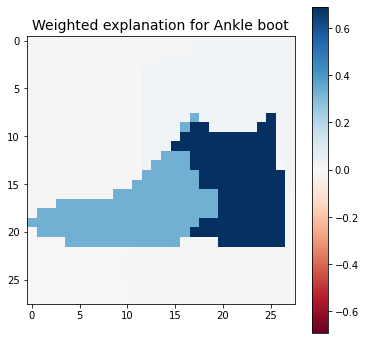

In [790]:
def plot_heatmap_for_label(explanation, label):
    
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[label])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    plt.figure(figsize=(6,6))
    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.title(f'Weighted explanation for {class_names[label]}', fontsize=14)
    plt.show()

plot_heatmap_for_label(explanation, explanation.top_labels[0])

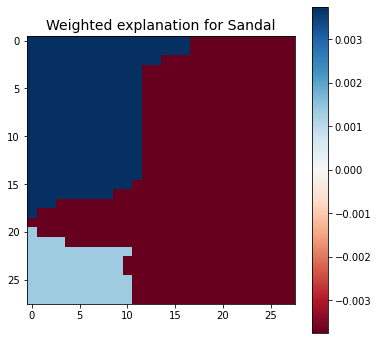

In [791]:
plot_heatmap_for_label(explanation, explanation.top_labels[2])

### Zadanie 1: 
Uzupełnić 2 poniższe TODO i wytłumaczyć LIME'em klasyfikację Random Forest dla dowolnego obrazka. Wygenerować 'explanation' dla kilku klas

In [ ]:
IMAGE_INDEX = #TODO pick some example image 
plot_predictions(cache[forest]["probabilities"][IMAGE_INDEX], y_test[IMAGE_INDEX], X_test[IMAGE_INDEX])

In [ ]:
def forest_predict_proba(X):
    pass #TODO implement me - use `forest` classifier

In [ ]:
segmenter = #TODO choose segmentation algorithm

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X_test[IMAGE_INDEX].reshape(28,28),
                                         forest_predict_proba,
                                         labels=class_names.keys(),
                                         top_labels=10,
                                         hide_color=0,
                                         num_samples=1000,
                                         segmentation_fn=segmenter)

### Zadanie 2:
Sprawdzić jak wyglądają explanation obrazka w zależności od segmentacji. (Wybrać bardzo małe sagmenty i bardzo duże)

In [ ]:
explainer = lime_image.LimeImageExplainer()

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=20, ratio=0.25)

explanation = explainer.explain_instance(X_test[IMAGE_INDEX].reshape(28,28),
                                         forest_predict_proba,
                                         labels=class_names.keys(),
                                         top_labels=10,
                                         hide_color=0,
                                         num_samples=1000,
                                         segmentation_fn=segmenter)



Let's try to explan some not correct classification with LIME. 

### An example of not correct Random Forest classification

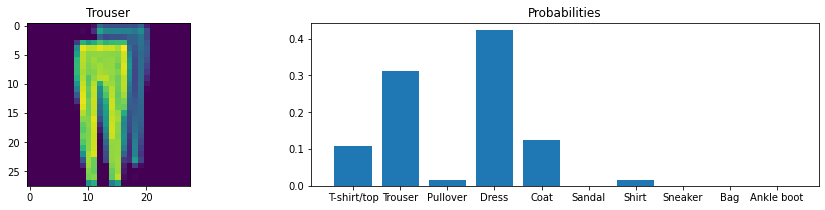

### The same image classified by SVM

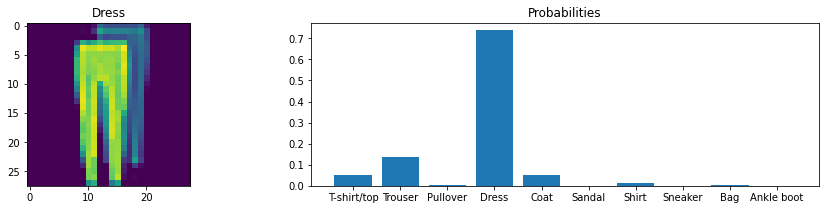

In [857]:
printmd('### An example of not correct Random Forest classification')
indices = plot_mistake(1, 3, forest)
index = indices[0]

printmd('### The same image classified by SVM')
plot_predictions(cache[svc]["probabilities"][index], 3, X_test[index])

In [858]:
explainer = lime_image.LimeImageExplainer()

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=2, ratio=0.15)

forest_explanation = explainer.explain_instance(X_test[index].reshape(28,28), 
                                         forest_predict_proba, 
                                         labels=class_names.keys(), 
                                         top_labels=10,
                                         hide_color=0, 
                                         num_samples=1000, 
                                         segmentation_fn=segmenter) 

svc_explanation = explainer.explain_instance(X_test[index].reshape(28,28), 
                                         svc_predict_proba, 
                                         labels=class_names.keys(), 
                                         top_labels=10,
                                         hide_color=0, 
                                         num_samples=1000, 
                                         segmentation_fn=segmenter) 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Quick look on segments

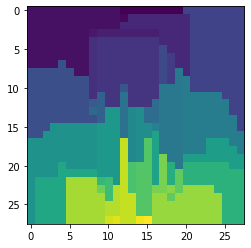

In [859]:
plt.imshow(forest_explanation.segments)
plt.show()

### Top label explanation for Random Forest

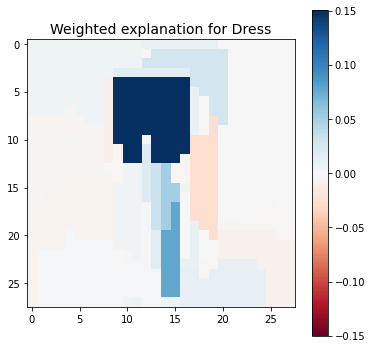

In [860]:
printmd('### Top label explanation for Random Forest')
plot_heatmap_for_label(forest_explanation, forest_explanation.top_labels[0])

### Top label explanation for SVM

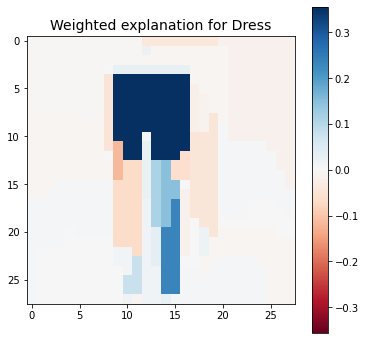

In [861]:
printmd('### Top label explanation for SVM')
plot_heatmap_for_label(svc_explanation, svc_explanation.top_labels[0])

### Trousers explanation for Random Forest

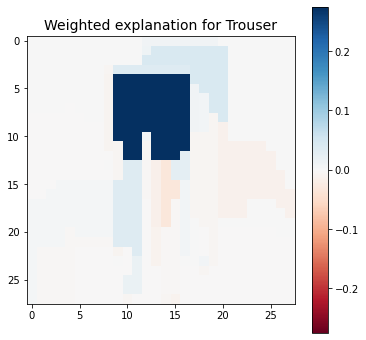

In [862]:
printmd('### Trousers explanation for Random Forest')
plot_heatmap_for_label(forest_explanation, 1)

### Trousers explanation for SVM

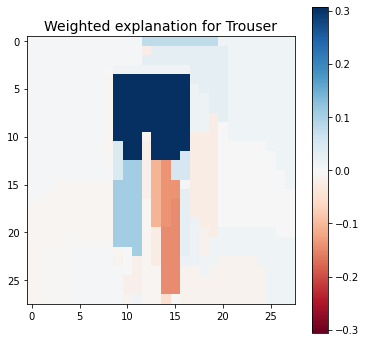

In [863]:
printmd('### Trousers explanation for SVM')
plot_heatmap_for_label(svc_explanation, 1)

### Zadanie 3

Generalnie obydwa klasyfikatory klasyfikują dość podobnie, ale znaleść różnicę i spróbować ją wytłumaczyć. Jest grupa Pulloverów która jest mylona z Coat przez Random Forest a przez SVN już nie - dlaczego? 